<a href="https://colab.research.google.com/github/tsiontegegn/Malariadetection/blob/main/2D_Anomalib_exploratory_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Thickness analysis**

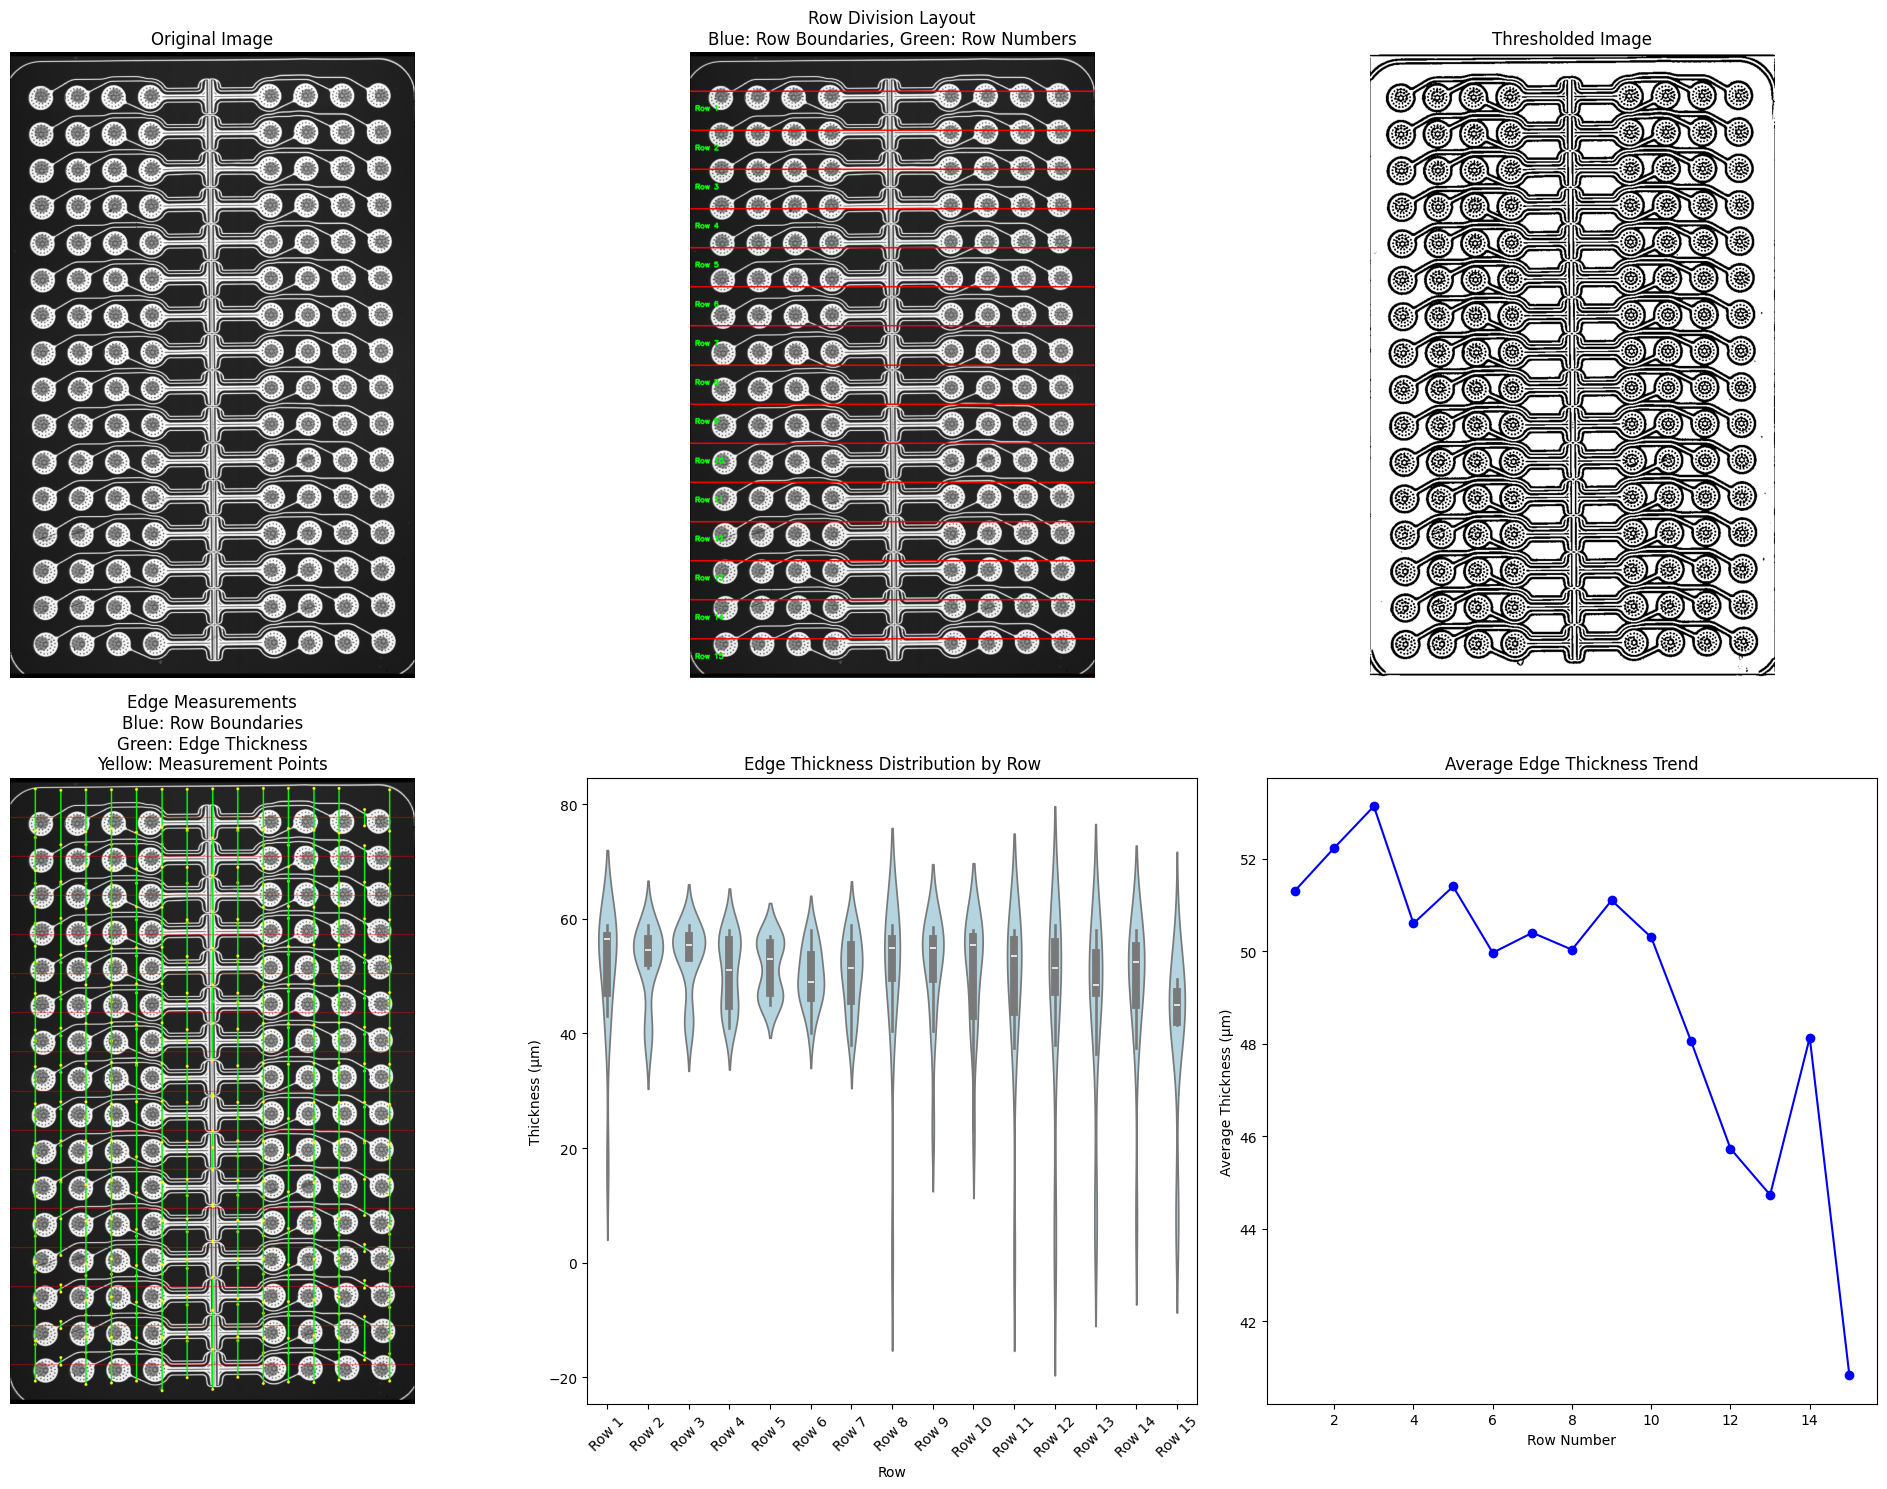


Edge Thickness Measurements (μm):
Row 1:
  Average: 51.30 ± 10.79
  Min: 17.00
  Max: 59.00
Row 2:
  Average: 52.23 ± 6.36
  Min: 38.00
  Max: 59.00
Row 3:
  Average: 53.13 ± 5.83
  Min: 40.50
  Max: 59.00
Row 4:
  Average: 50.60 ± 6.06
  Min: 41.00
  Max: 58.00
Row 5:
  Average: 51.40 ± 4.78
  Min: 45.00
  Max: 57.00
Row 6:
  Average: 49.97 ± 5.00
  Min: 40.00
  Max: 58.00
Row 7:
  Average: 50.40 ± 6.26
  Min: 38.00
  Max: 59.00
Row 8:
  Average: 50.03 ± 13.98
  Min: 1.50
  Max: 59.00
Row 9:
  Average: 51.10 ± 9.16
  Min: 23.50
  Max: 58.50
Row 10:
  Average: 50.30 ± 9.73
  Min: 23.00
  Max: 58.00
Row 11:
  Average: 48.07 ± 14.01
  Min: 1.50
  Max: 58.00
Row 12:
  Average: 45.73 ± 17.14
  Min: 1.00
  Max: 59.00
Row 13:
  Average: 44.73 ± 15.39
  Min: 7.50
  Max: 58.00
Row 14:
  Average: 48.13 ± 12.28
  Min: 7.50
  Max: 58.00
Row 15:
  Average: 40.83 ± 13.45
  Min: 7.50
  Max: 55.50


In [9]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

class MicrofluidicRowAnalyzer:
    def __init__(self, image_path, pixel_to_micron_ratio=0.5):
        self.image_path = image_path
        self.pixel_to_micron_ratio = pixel_to_micron_ratio
        self.original_image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

        if self.original_image is None:
            raise ValueError(f"Could not load image: {image_path}")

    def preprocess_image(self):
        """Preprocess the image for edge detection"""
        blurred = cv2.GaussianBlur(self.original_image, (5,5), 0)
        threshold = cv2.adaptiveThreshold(
            blurred,
            255,
            cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
            cv2.THRESH_BINARY,
            11,
            2
        )
        return blurred, threshold

    def create_row_visualization(self, num_rows=18):
        """
        Create a visualization showing how the image is divided into rows
        """
        height, width = self.original_image.shape
        row_height = height / (num_rows + 1)

        # Create a color image for visualization
        vis_image = cv2.cvtColor(self.original_image, cv2.COLOR_GRAY2RGB)

        # Draw horizontal lines for row divisions
        for row in range(num_rows + 1):
            y_position = int((row + 1) * row_height)
            cv2.line(vis_image, (0, y_position), (width, y_position), (255, 0, 0), 2)

            # Add row numbers
            if row < num_rows:
                text_y = int((row + 1.5) * row_height)
                cv2.putText(vis_image, f'Row {row + 1}',
                          (10, text_y),
                          cv2.FONT_HERSHEY_SIMPLEX,
                          0.5, (0, 255, 0), 2)

        return vis_image

    def analyze_row_edges(self, num_rows=18, num_samples=15):
        """
        Analyze edge thickness between rows of channels
        """
        _, threshold = self.preprocess_image()
        height, width = threshold.shape

        # Create visualization image
        vis_image = cv2.cvtColor(self.original_image, cv2.COLOR_GRAY2RGB)
        row_height = height / (num_rows + 1)
        edge_measurements = []

        # Draw row divisions
        for row in range(num_rows + 1):
            y_position = int((row + 1) * row_height)
            cv2.line(vis_image, (0, y_position), (width, y_position), (255, 0, 0), 1)

        # Analyze each row
        for row in range(num_rows):
            y_position = int((row + 1) * row_height)
            row_measurements = []

            for sample in range(num_samples):
                x_position = int(width * (sample + 1) / (num_samples + 1))

                window_height = int(row_height * 1.5)
                y_start = max(0, y_position - window_height//2)
                y_end = min(height, y_position + window_height//2)

                vertical_slice = threshold[y_start:y_end, x_position]
                edges = np.where(np.diff(vertical_slice) != 0)[0]

                if len(edges) >= 2:
                    edge_thickness = edges[-1] - edges[0]
                    thickness_microns = edge_thickness * self.pixel_to_micron_ratio
                    row_measurements.append(thickness_microns)

                    # Draw measurement points
                    y1 = y_start + edges[0]
                    y2 = y_start + edges[-1]
                    cv2.line(vis_image, (x_position, y1), (x_position, y2), (0, 255, 0), 2)

                    # Draw sample points
                    cv2.circle(vis_image, (x_position, y1), 3, (255, 255, 0), -1)
                    cv2.circle(vis_image, (x_position, y2), 3, (255, 255, 0), -1)

            if row_measurements:
                edge_measurements.append(row_measurements)

        return edge_measurements, vis_image

    def visualize_analysis(self, num_rows=15):
        """
        Visualize the analysis results with row divisions and violin plot
        """
        plt.figure(figsize=(20, 15))

        # Original Image
        plt.subplot(231)
        plt.imshow(self.original_image, cmap='gray')
        plt.title('Original Image')
        plt.axis('off')

        # Row Division Visualization
        row_vis = self.create_row_visualization(num_rows)
        plt.subplot(232)
        plt.imshow(row_vis)
        plt.title('Row Division Layout\nBlue: Row Boundaries, Green: Row Numbers')
        plt.axis('off')

        # Preprocessed Images
        blurred, threshold = self.preprocess_image()
        plt.subplot(233)
        plt.imshow(threshold, cmap='gray')
        plt.title('Thresholded Image')
        plt.axis('off')

        # Edge Analysis
        measurements, vis_image = self.analyze_row_edges(num_rows)
        plt.subplot(234)
        plt.imshow(vis_image)
        plt.title('Edge Measurements\nBlue: Row Boundaries\nGreen: Edge Thickness\nYellow: Measurement Points')
        plt.axis('off')

        if measurements:
            # Violin plot
            plt.subplot(235)
            # Prepare data for violin plot
            violin_data = []
            row_labels = []
            for row_idx, row_measurements in enumerate(measurements, 1):
                if row_measurements:
                    violin_data.extend(row_measurements)
                    row_labels.extend([f'Row {row_idx}'] * len(row_measurements))

            # Create DataFrame for seaborn
            df = pd.DataFrame({
                'Row': row_labels,
                'Thickness': violin_data
            })

            # Create violin plot
            sns.violinplot(data=df, x='Row', y='Thickness', color='lightblue')
            plt.xticks(rotation=45)
            plt.title('Edge Thickness Distribution by Row')
            plt.ylabel('Thickness (μm)')

            # Average thickness trend
            plt.subplot(236)
            averages = [np.mean(row) for row in measurements if row]
            plt.plot(range(1, len(averages) + 1), averages, 'b-o')
            plt.title('Average Edge Thickness Trend')
            plt.ylabel('Average Thickness (μm)')
            plt.xlabel('Row Number')

        plt.tight_layout()
        plt.show()

        # Print measurements
        print("\nEdge Thickness Measurements (μm):")
        for row_idx, row_measurements in enumerate(measurements, 1):
            if row_measurements:
                avg_thickness = np.mean(row_measurements)
                std_thickness = np.std(row_measurements)
                print(f"Row {row_idx}:")
                print(f"  Average: {avg_thickness:.2f} ± {std_thickness:.2f}")
                print(f"  Min: {min(row_measurements):.2f}")
                print(f"  Max: {max(row_measurements):.2f}")

def main(image_path):
    try:
        analyzer = MicrofluidicRowAnalyzer(image_path, pixel_to_micron_ratio=0.5)
        analyzer.visualize_analysis()
    except Exception as e:
        print(f"An error occurred: {e}")

if __name__ == "__main__":
    sample_image_path = "/content/drive/MyDrive/2D_AnomalyDetection/ok/2024-09-02_130544_243301-11_tray-b-4-d_L2_part_2_ds_0_without_ears_res_0.001.png"
    main(sample_image_path)

**Color analysis**

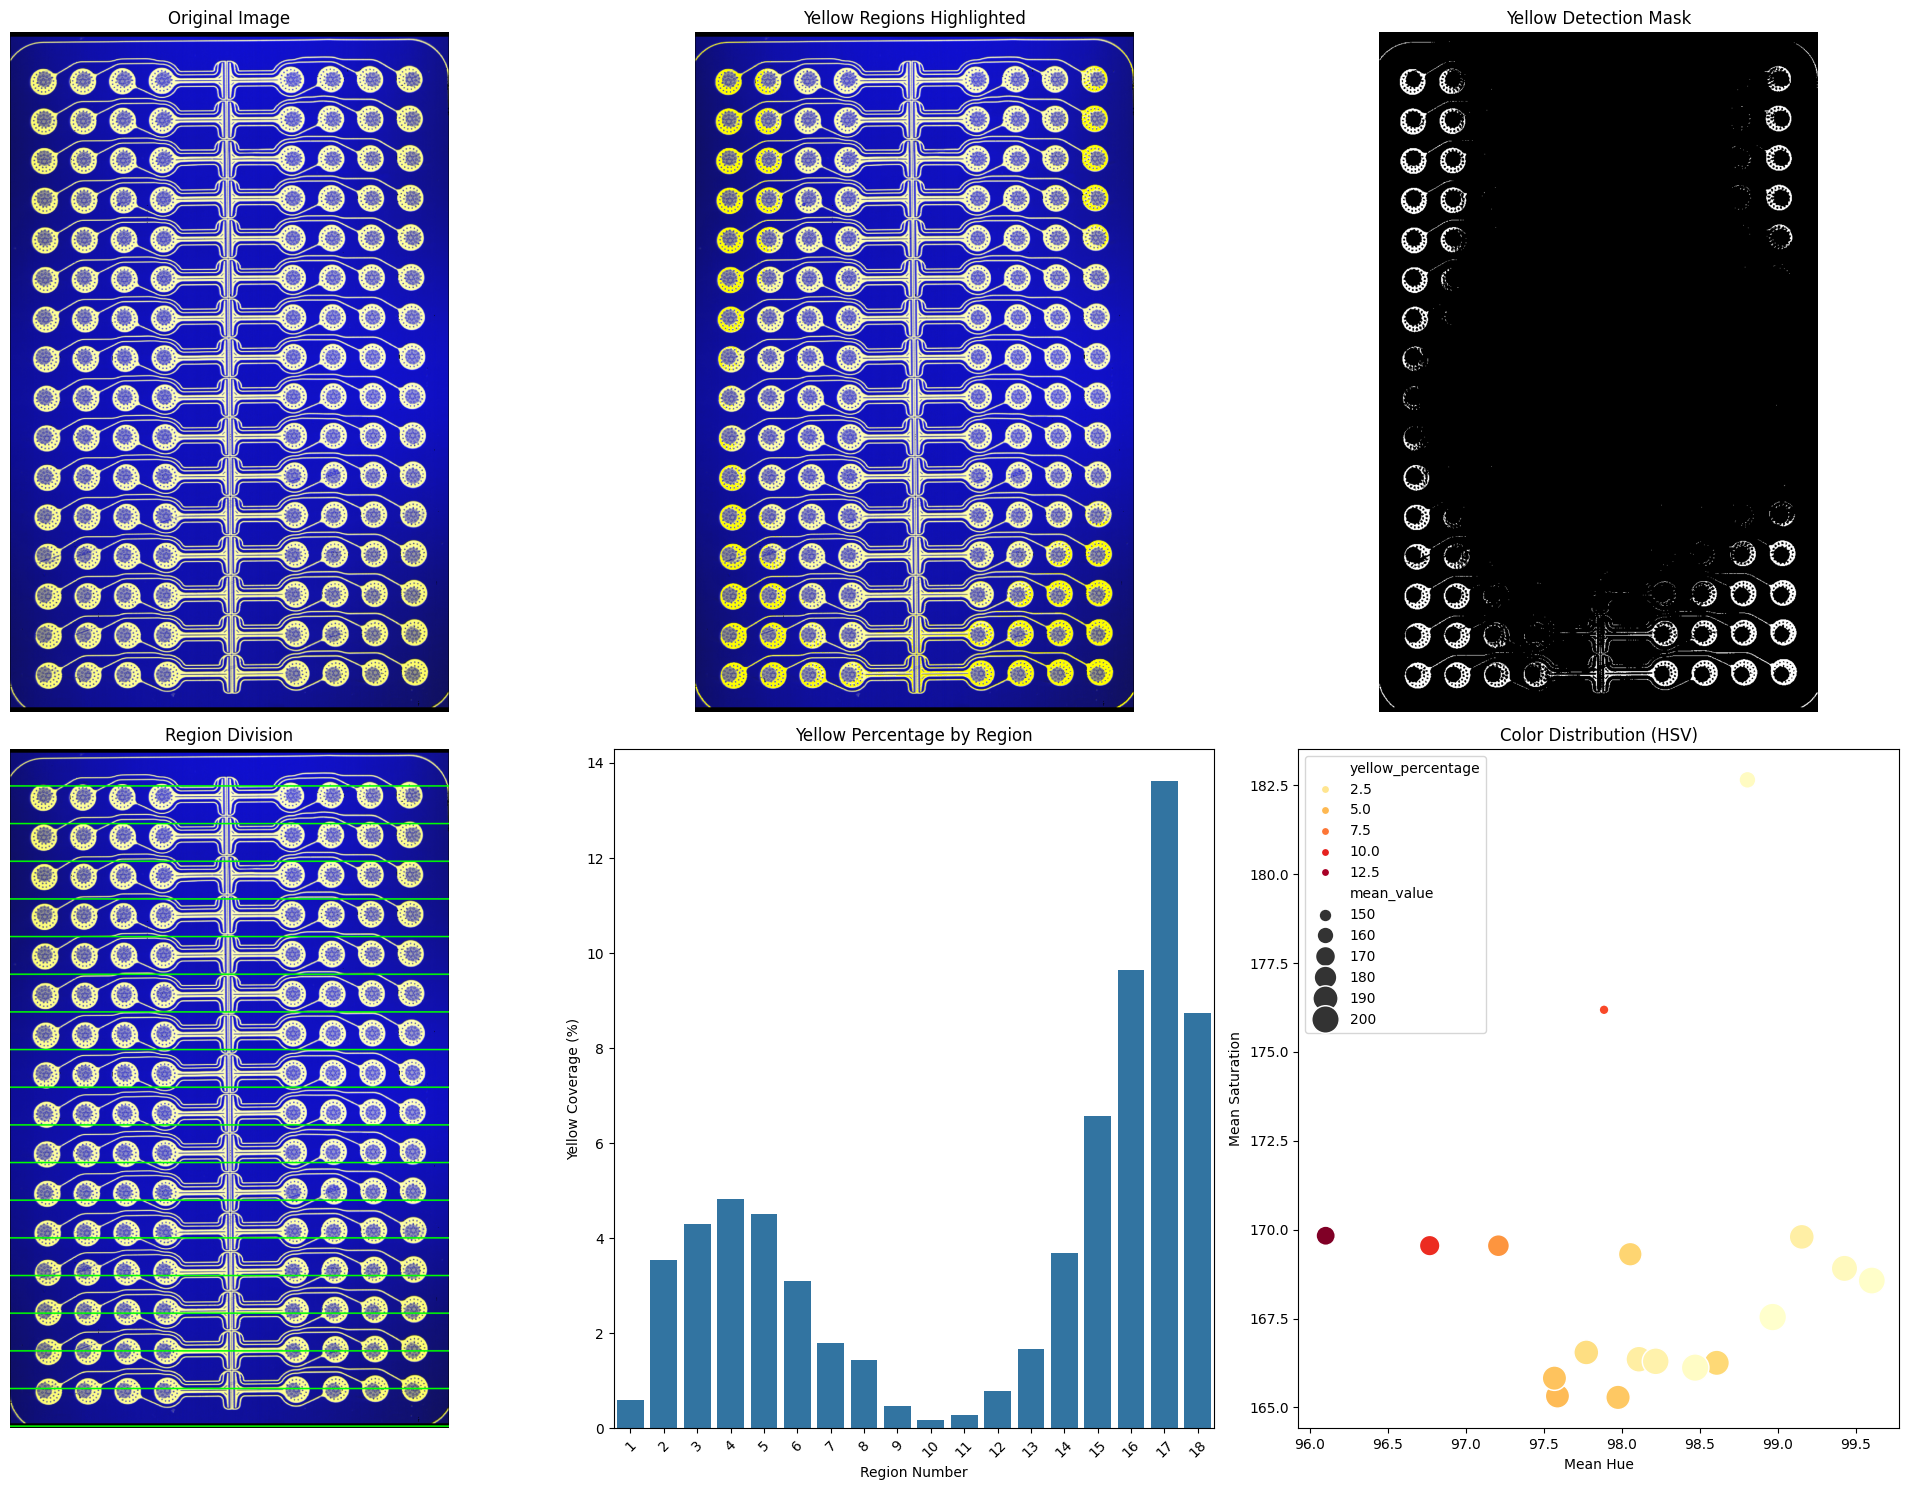


Color Analysis Statistics:

Regions with significant yellow content (>5%):
Region 15: 6.56% yellow coverage
Region 16: 9.65% yellow coverage
Region 17: 13.61% yellow coverage
Region 18: 8.74% yellow coverage


In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

class MicrofluidicColorAnalyzer:
    def __init__(self, image_path):
        self.image_path = image_path
        # Read image in BGR format
        self.original_image = cv2.imread(image_path)
        if self.original_image is None:
            raise ValueError(f"Could not load image: {image_path}")
        # Convert BGR to HSV for better color analysis
        self.hsv_image = cv2.cvtColor(self.original_image, cv2.COLOR_BGR2HSV)

    def detect_yellow_regions(self, yellow_lower=(20, 100, 100), yellow_upper=(40, 255, 255)):
        """
        Detect yellow regions in the image using HSV color space
        Args:
            yellow_lower: Lower bound of yellow in HSV
            yellow_upper: Upper bound of yellow in HSV
        Returns:
            mask: Binary mask of yellow regions
            highlighted_image: Original image with yellow regions highlighted
        """
        # Create mask for yellow colors
        yellow_mask = cv2.inRange(self.hsv_image,
                                np.array(yellow_lower),
                                np.array(yellow_upper))

        # Apply mask to original image
        yellow_regions = cv2.bitwise_and(self.original_image,
                                       self.original_image,
                                       mask=yellow_mask)

        # Create highlighted image
        highlighted = self.original_image.copy()
        highlighted[yellow_mask > 0] = [0, 255, 255]  # Highlight in pure yellow

        return yellow_mask, highlighted, yellow_regions

    def analyze_color_distribution(self, num_regions=18):
        """
        Analyze color distribution across different regions of the chip
        """
        height, width = self.original_image.shape[:2]
        region_height = height // num_regions

        color_stats = []
        visualization = self.original_image.copy()

        # Analyze each region
        for i in range(num_regions):
            y_start = i * region_height
            y_end = (i + 1) * region_height

            region = self.hsv_image[y_start:y_end, :]

            # Calculate color statistics for the region
            mean_hue = np.mean(region[:, :, 0])
            mean_saturation = np.mean(region[:, :, 1])
            mean_value = np.mean(region[:, :, 2])

            # Calculate yellow percentage
            yellow_mask, _, _ = self.detect_yellow_regions()
            region_mask = yellow_mask[y_start:y_end, :]
            yellow_percentage = (np.sum(region_mask > 0) / region_mask.size) * 100

            color_stats.append({
                'region': i + 1,
                'mean_hue': mean_hue,
                'mean_saturation': mean_saturation,
                'mean_value': mean_value,
                'yellow_percentage': yellow_percentage
            })

            # Draw region boundaries
            cv2.line(visualization, (0, y_end), (width, y_end), (0, 255, 0), 2)

        return pd.DataFrame(color_stats), visualization

    def visualize_analysis(self):
        """
        Create comprehensive visualization of color analysis
        """
        plt.figure(figsize=(20, 15))

        # Original Image
        plt.subplot(231)
        plt.imshow(cv2.cvtColor(self.original_image, cv2.COLOR_BGR2RGB))
        plt.title('Original Image')
        plt.axis('off')

        # Yellow Detection
        yellow_mask, highlighted, yellow_regions = self.detect_yellow_regions()
        plt.subplot(232)
        plt.imshow(cv2.cvtColor(highlighted, cv2.COLOR_BGR2RGB))
        plt.title('Yellow Regions Highlighted')
        plt.axis('off')

        # Yellow Mask
        plt.subplot(233)
        plt.imshow(yellow_mask, cmap='gray')
        plt.title('Yellow Detection Mask')
        plt.axis('off')

        # Color Statistics
        stats_df, region_vis = self.analyze_color_distribution()

        # Region visualization
        plt.subplot(234)
        plt.imshow(cv2.cvtColor(region_vis, cv2.COLOR_BGR2RGB))
        plt.title('Region Division')
        plt.axis('off')

        # Yellow percentage by region
        plt.subplot(235)
        sns.barplot(data=stats_df, x='region', y='yellow_percentage')
        plt.title('Yellow Percentage by Region')
        plt.xlabel('Region Number')
        plt.ylabel('Yellow Coverage (%)')
        plt.xticks(rotation=45)

        # HSV distributions
        plt.subplot(236)
        sns.scatterplot(data=stats_df, x='mean_hue', y='mean_saturation',
                       size='mean_value', hue='yellow_percentage',
                       palette='YlOrRd', sizes=(50, 400))
        plt.title('Color Distribution (HSV)')
        plt.xlabel('Mean Hue')
        plt.ylabel('Mean Saturation')

        plt.tight_layout()
        plt.show()

        # Print detailed statistics
        print("\nColor Analysis Statistics:")
        print("\nRegions with significant yellow content (>5%):")
        significant_yellow = stats_df[stats_df['yellow_percentage'] > 5]
        if not significant_yellow.empty:
            for _, row in significant_yellow.iterrows():
                print(f"Region {int(row['region'])}: {row['yellow_percentage']:.2f}% yellow coverage")
        else:
            print("No regions with significant yellow content found")

def main(image_path):
    try:
        analyzer = MicrofluidicColorAnalyzer(image_path)
        analyzer.visualize_analysis()
    except Exception as e:
        print(f"An error occurred: {e}")

if __name__ == "__main__":
    sample_image_path =  "/content/drive/MyDrive/2D_AnomalyDetection/ok/2024-09-02_130544_243301-11_tray-b-4-d_L2_part_2_ds_0_without_ears_res_0.001.png"
    #sample_image_path =  "/content/drive/MyDrive/2D_AnomalyDetection/ok"
    main(sample_image_path)